## Cargando los grafos de prueba

In [1]:
import igraph
import dgl
import torch
import heapq
import time
import progressbar
import pickle
import matplotlib.pyplot as plt
import os
import gc
import networkx as nx
from datetime import datetime

In [2]:
PATH = "data/"
PATH_INSTANCES = "data/ER_graphs/train/"
PATH_SAVE_TRAINS = "runs/"
FEATURE_TYPE = "1"
HIDDEN_FEATS = [32]*6
input_dim = 32
directed_train = False
use_cuda = False

### Funciones

In [2]:
def get_rev_dgl(graph, feature_type='0', feature_dim=None, is_directed=False, use_cuda=False):
    """get dgl graph from igraph
    """
    
    src, dst = zip(*graph.get_edgelist())

    if use_cuda:
        dglgraph = dgl.graph((dst, src)).to(torch.device("cuda:0"))
    else:
        dglgraph = dgl.graph((dst, src))
        
        
    if not is_directed:
        dglgraph.add_edges(src, dst)

    if use_cuda:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim).cuda()
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float().cuda()

    else:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim)
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float()
        
    return dglgraph

def gen_one_feature(graph, feature_dim):
    """Generate all-one features
    """
    return torch.ones(graph.vcount(), feature_dim)


FEATURE_TYPE_DICT = {
    "1": gen_one_feature,
}

In [27]:
Graphs = [graph for graph in os.listdir(PATH) if ".txt" in graph]
#"""
MeanNodes = []

N = len(Graphs)

for file in progressbar.progressbar(Graphs):
    graph = igraph.Graph().Read_Edgelist(
        f"{PATH}{file}", directed=False)

    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda = False)
    
    MeanNodes.append(dglgraph.num_nodes())
#"""
print(f"MEAN NODES: {np.mean(MeanNodes):.2f}\nSTD:{np.std(MeanNodes):.2f}\nMAX: {np.max(MeanNodes):.2f}\nMIN: {np.min(MeanNodes):.2f}")

100% (29 of 29) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


MEAN NODES: 44170.41
STD:67189.83
MAX: 317080.00
MIN: 620.00


(array([7., 3., 4., 1., 2., 3., 1., 2., 1., 2.]),
 array([  620. ,  6931.1, 13242.2, 19553.3, 25864.4, 32175.5, 38486.6,
        44797.7, 51108.8, 57419.9, 63731. ]),
 <BarContainer object of 10 artists>)

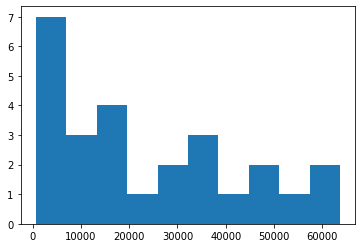

In [38]:
MeanNodes = np.array(MeanNodes)
plt.hist(MeanNodes[MeanNodes < 100_000], bins = 10)

## Convirtiendo dimacs a txt

In [8]:
PATH = "../BRKGA/instances/dimacs/"
NEW_PATH = "../BRKGA/instances/txt/"

In [9]:
Graphs = [graph for graph in os.listdir(PATH)]

In [10]:
Graphs

['Amazon0302.dimacs',
 'Amazon0312.dimacs',
 'Amazon0505.dimacs',
 'Amazon0601.dimacs',
 'com-dblp.ungraph.dimacs',
 'com-youtube.ungraph.dimacs',
 'deezer_HR.dimacs',
 'ego-facebook.dimacs',
 'gemsec_facebook_artist.dimacs',
 'graph_actors_dat.dimacs',
 'graph_CA-AstroPh.dimacs',
 'graph_CA-CondMat.dimacs',
 'graph_CA-GrQc.dimacs',
 'graph_CA-HepPh.dimacs',
 'graph_CA-HepTh.dimacs',
 'graph_dolphins.dimacs',
 'graph_Email-Enron.dimacs',
 'graph_football.dimacs',
 'graph_jazz.dimacs',
 'graph_karate.dimacs',
 'graph_ncstrlwg2.dimacs',
 'loc-gowalla_edges.dimacs',
 'musae_git.dimacs',
 'soc-gplus.dimacs',
 'socfb-Brandeis99.dimacs',
 'socfb-Mich67.dimacs',
 'socfb-nips-ego.dimacs']

In [36]:
def Dimacs2Txt(ruta, nuevaruta):
    file1 = open(ruta, 'rb')
    Lines = file1.readlines()
    newname = ".".join((PATH+file).split("/")[-1].split(".")[:-1])+".txt"
    file2 = open(nuevaruta+newname, 'wb')
    file1.close()
    for line in Lines[1:]:
        v = line.strip().split()
        file2.write(f"{int(v[1])-1} {int(v[2])-1}")
        file2.write('\n')
    file2.close()
    return newname


In [12]:
for file in progressbar.progressbar(Graphs):
    Dimacs2Txt(PATH+file, NEW_PATH)

100% (27 of 27) |########################| Elapsed Time: 0:01:21 Time:  0:01:21


In [ ]:
# los txt de instances son los de prueba para TSS
# Los utilizados en el FastCava son de puro entrenamiento

In [24]:
5*10**-4

0.0005

### Creando grafos totalmente conectados

In [136]:
Cont = 0
NumGrafos = 20
n = 1000
p = 10/n
INSTANCES = []

while True:
    G = nx.erdos_renyi_graph(n, p, directed = False)
    AllConected = True if len([i for i in nx.connected_components(G)]) == 1 else False
    if AllConected:
        INSTANCES.append(G)
        Cont += 1
    if Cont == NumGrafos:
        break
        

### Salvando los grafos

In [137]:
for i in range(len(INSTANCES)):
    igraph.Graph().from_networkx(INSTANCES[i]).write_pickle(f"{PATH_INSTANCES}ER_{i}.pkl")

### Recuperando las instancias guardadas

In [9]:
ERInstances = [graph for graph in os.listdir(PATH_INSTANCES)]

In [13]:
graphs = []
dglgraphs = []

for er in progressbar.progressbar(ERInstances):
    graph = igraph.Graph().Read_Pickle(PATH_INSTANCES+er)
    
    graphs.append(graph)
    
    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
    dglgraphs.append(dglgraph)

100% (15 of 15) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [41]:
ERInstances = [graph for graph in os.listdir('data/ER_graphs/train/pkl/')]
#ERInstances = [graph for graph in os.listdir('data/ER_graphs/test/pkl/')]

for er in progressbar.progressbar(ERInstances):
    graph = igraph.Graph().Read_Pickle('data/ER_graphs/train/pkl/'+er)
    graph2dimacs('data/ER_graphs/train/dimacs/', graph.to_networkx(), er)

100% (15 of 15) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [31]:
ERInstances

['dimacs', 'pkl']

In [39]:
def graph2dimacs(path, g, name):
    """
    path [str] - where to save
    graph [networkxs] - object to save
    """
    #g = graph.to_networkx()
    name = name.split(".")[0]
    dimacs_filename = f"{name}.dimacs"

    with open(path + dimacs_filename, "w") as f:
        # write the header
        f.write("p edge {} {}\n".format(g.number_of_nodes(), g.number_of_edges()))
        # now write all edges
        for u, v in g.edges():
            f.write("e {} {}\n".format(int(u+1), int(v+1)))

In [146]:
PATH_TO_TRAIN = "data/ER_graphs/train/"
PATH_TO_TEST = "data/ER_graphs/test/"

TRAIN_LIST = [graph for graph in os.listdir(PATH_TO_TRAIN)]

In [147]:
graphs = []
dglgraphs = []

for file in TRAIN_LIST:
    print(f"Cargando {PATH_TO_TRAIN+file} ...")
    graph = igraph.Graph().Read_Pickle(PATH_TO_TRAIN+file)
    graphs.append(graph)
    
    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
    dglgraphs.append(dglgraph)

Cargando data/ER_graphs/train/ER_0.pkl ...
Cargando data/ER_graphs/train/ER_1.pkl ...
Cargando data/ER_graphs/train/ER_10.pkl ...
Cargando data/ER_graphs/train/ER_11.pkl ...
Cargando data/ER_graphs/train/ER_12.pkl ...
Cargando data/ER_graphs/train/ER_13.pkl ...
Cargando data/ER_graphs/train/ER_14.pkl ...
Cargando data/ER_graphs/train/ER_2.pkl ...
Cargando data/ER_graphs/train/ER_3.pkl ...
Cargando data/ER_graphs/train/ER_4.pkl ...
Cargando data/ER_graphs/train/ER_5.pkl ...
Cargando data/ER_graphs/train/ER_6.pkl ...
Cargando data/ER_graphs/train/ER_7.pkl ...
Cargando data/ER_graphs/train/ER_8.pkl ...
Cargando data/ER_graphs/train/ER_9.pkl ...


In [148]:
graphs

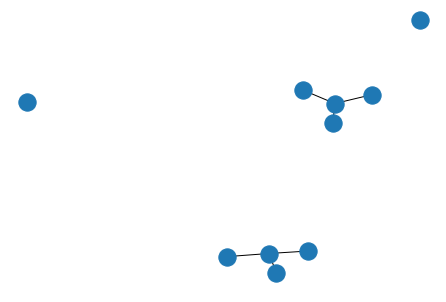

In [118]:
G = nx.erdos_renyi_graph(10, 0.1, directed = False)
nx.draw(G)

### Maximum Degree Heuristic

In [345]:
theta = 0.1

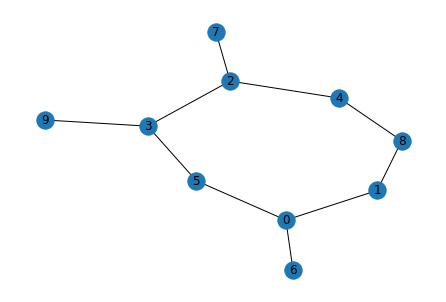

In [355]:
n = 10
while True:
    G = nx.erdos_renyi_graph(n, 0.2, directed = False)
    AllConected = True if len([i for i in nx.connected_components(G)]) == 1 else False
    if AllConected:
        break
nx.draw(G, with_labels=1)

In [453]:
F = MDH(G, 0.2, print_ = False)
len(F)

16

In [441]:
len(F)

216

In [4]:
import igraph
import dgl
import torch
import numpy as np
import networkx as nx

def MDH(G, threshold = 0.5, print_ =False):
    """
    Aplica la Heurística del Grado Mínimo para obtener el conjunto 
    más pequeño posible de nodos.
    
    In:
    G - Grafo networkx
    threshold = 0.5 - Umbral de infección
    print_ = False - Mostrar avance de infección
    
    out:
    solution - Conjunto mínimo encontrado de nodos infectados
    """
    
    NodesDegree = np.array(nx.degree(G))
    Infected = [k for k in nx.isolates(G)]
    # Si llega a existir nodos aislados, estos harán que el método sea trivial
    # Por eso los infectados iniciales son los aislados
    Solution = []
    while len(NodesDegree) != 0 and len(Infected) != len(G.nodes()):

        posMaxDegreeNode = np.argmax(NodesDegree.T[1])
        MaxDegreeNode = NodesDegree[posMaxDegreeNode][0]

        NodesDegree = np.delete(NodesDegree, posMaxDegreeNode, axis=0)

        Solution.append(MaxDegreeNode)
        Infected.append(MaxDegreeNode)
            
        InfectedTemp = []
        while len(InfectedTemp) != len(Infected):
            InfectedTemp = Infected.copy()
            for Inf in InfectedTemp:
                for neighborL1 in nx.neighbors(G, Inf):

                    if neighborL1 in Infected:
                        continue

                    TotalNeighbors = [v for v in nx.neighbors(G, neighborL1)]
                    NeighborsInfedted = [v for v in TotalNeighbors if v in Infected]

                    ratio = len(NeighborsInfedted)/len(TotalNeighbors)
                    if ratio > threshold:
                        Infected.append(neighborL1)
                        NodesDegree = np.delete(NodesDegree, np.where(NodesDegree.T[0] == neighborL1)[0], axis = 0)
        if print_:
            print(f"{len(Infected)/len(G.nodes()):.3f} infectado")
    return Solution, len(Infected)

### Revisar si un conjunto de nodos infecta toda la red

In [5]:
def CheckInfect(G, Infected, threshold):
    """
    Recibe Una red G, conjunto de nodos infectados y el umbral
    Propaga la infección en la red todo lo que puede
    Regresa verdadero si se ha infectado toda la red o
    falso en lo contrario
    
    In:
    G - grafo networkx
    Infected - Conjunto de nodos iniciales infectados
    threshold - Umbral de infección
    """
    InfectedTemp = []
    while len(InfectedTemp) != len(Infected):
        InfectedTemp = Infected.copy()
        for Inf in InfectedTemp:
            for neighborL1 in nx.neighbors(G, Inf):
                if neighborL1 in Infected:
                    continue
                
                TotalNeighbors = [v for v in nx.neighbors(G, neighborL1)]
                    
                NeighborsInfedted = [v for v in TotalNeighbors if v in Infected]
                
                ratio = len(NeighborsInfedted)/len(TotalNeighbors)
                if ratio > threshold:
                    Infected.append(neighborL1)
    return len(Infected) == len(G.nodes()), len(Infected)/len(G.nodes())


In [381]:
CheckInfect(G, [1,5,2], 0.7)

(False, 0.4)

## Cargando la red entrenada

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.softmax import edge_softmax
# Guanhao's GRAT
class GRATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        # TODO: why not another linear layer before entering the net
        super(GRATLayer, self).__init__()
        # linear layer
        self.fc = nn.Linear(in_feats, out_feats, bias=True)  # bias=True in Guanhao's original code
        
        # attention layer
        self.attn_fc = nn.Linear(2 * in_feats, 1, bias=True)  # bias=True in Guanhao's original code

        # initialize parameters
        # self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        h2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(h2)
        return {'e': torch.relu(a)}

    def message_func(self, edges):
        return {'h': edges.src['h'] * edges.data['alpha']}  # message divided by weight

    def reduce_func(self, nodes):
        return {'h': torch.sum(nodes.mailbox['h'], dim=1)}

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            # Equation (2)
            g.apply_edges(self.edge_attention)  # calculate e_{ij}

            # Calculate softmax on source code -> on the reversed graph
            rg = g.reverse(copy_ndata=False, copy_edata=True)
            g.edata['alpha'] = edge_softmax(rg, rg.edata['e'])
            
            # Convolution
            g.update_all(self.message_func, self.reduce_func)
            
            g.ndata['h'] = self.fc(g.ndata['h'])
            h = g.ndata['h']
            return h

import torch.nn as nn


class GRAT3_(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, out_feats, *args):
        super(GRAT3_, self).__init__()
        self.grat1 = GRATLayer(in_feats, hidden_feats1)
        self.grat2 = GRATLayer(hidden_feats1, hidden_feats2)
        self.grat3 = GRATLayer(hidden_feats2, out_feats)

    def forward(self, g, feature):
        h = torch.relu(self.grat1(g, feature))
        h = torch.relu(self.grat2(g, h))
        h = self.grat3(g, h)
        return h


class GRAT3(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, *args):
        super(GRAT3, self).__init__()
        self.grat = GRAT3_(in_feats, hidden_feats1, hidden_feats2, 1, *args)  # out_feats=1

    def forward(self, g, feature):
        h = self.grat(g, feature)
        h = torch.sigmoid(h)
        return h

In [32]:
RUNS_LIST = [run for run in os.listdir(PATH_SAVE_TRAINS) if ".pt" in run]
print(RUNS_LIST)

PATH_TO_TEST = "data/ER_graphs/test/"
TEST_LIST = [graph for graph in os.listdir(PATH_TO_TEST)]

['GRAT_seed_13_10-15_17-40.pt']


In [33]:
net = GRAT3(*HIDDEN_FEATS)
net.load_state_dict(torch.load(PATH_SAVE_TRAINS+'GRAT_seed_13_10-15_17-40.pt'))
if use_cuda:
    net.cuda()

In [34]:
graphs = []
dglgraphs = []

for file in TEST_LIST:
    print(f"Cargando {PATH_TO_TEST+file} ...")
    graph = igraph.Graph().Read_Pickle(PATH_TO_TEST+file)
    graphs.append(graph)
    
    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
    dglgraphs.append(dglgraph)

Cargando data/ER_graphs/test/ER_15.pkl ...
Cargando data/ER_graphs/test/ER_16.pkl ...
Cargando data/ER_graphs/test/ER_17.pkl ...
Cargando data/ER_graphs/test/ER_18.pkl ...
Cargando data/ER_graphs/test/ER_19.pkl ...


In [35]:
out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)

In [495]:
#for k in range(len(dglgraph.num_nodes())):
G = graph.to_networkx()
threshold = 0.5
kMax = int(len(G.nodes()) * threshold)
kMin = 0
j = []
for _ in progressbar.progressbar(range(10)):
    _, Infected = torch.topk(out, kMax)
    
    Inf = CheckInfect(G, list(Infected.numpy()), threshold)
    
    if Inf[0]:
        kMax = kMax - (kMax - kMin)//2
    else:
        t = kMax
        kMax = kMax + (kMax - kMin)//2
        kMin = t
    if (kMax - kMin) == 1:
        break
        
print(f"El mejor es {kMax}")

 80% (8 of 10) |####################     | Elapsed Time: 0:00:18 ETA:   0:00:07

El mejor es 243


In [494]:
_, Infected = torch.topk(out, 243)
CheckInfect(G, list(Infected.numpy()), threshold)

(True, 1.0)

In [ ]:
records = []
repeat = 3
ts = np.zeros(repeat)
for i in range(repeat):
    # Select seeds
    t_start = time.time()
    ## =================================================================================================
    # Este es el output de la red, en donde se tienen las probabilidades de que cada nodo sea parte de la
    # solución final
    ## =================================================================================================
    out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)#!!!!!!!!!!!!!!
    ## =================================================================================================
    # Esta función regresas el k nodos con la máxima influencia
    _, nn_seeds = torch.topk(out, k)
    ## =================================================================================================
    ts[i] = (time.time() - t_start)

# Evaluate time
t_mean = ts.mean() 
t_std = ts.std() / np.sqrt(repeat)

## =================================================================================================
# Nodos cubiertos del total, para nosotros d = 1 ya que solo se puede llegar al siguiente
# baselines.heuristics.py -> get_influence_d
# 
## =================================================================================================
n_covered = get_influence(graph, nn_seeds)
n, m = graph.vcount(), graph.ecount()
## =================================================================================================
print(f"k: {k}. Coverage: {n_covered}/{n}={n_covered/n:.2f}. Time: {t_mean:.2f} ({t_std:.2f})")
model_name = "GRAT3"
# Write to records
records.append({
    "graph": graph_name,
    "model": model_name,
    "seed": seed,
    "n": n,
    "m": m,
    "d": d,
    "k": k,
    "n_covered": n_covered,
    "coverage": n_covered/n,
    "t_mean": t_mean,
    "t_std": t_std,
})

## Métrica rápida sobre el dataset del TSS

In [4]:
PATH_TO_TEST = "../BRKGA/instances/txt/"

In [6]:
Graphs = [graph for graph in os.listdir(PATH_TO_TEST)]
Graphs = ['soc-gplus.txt']

In [7]:
graphs = []
dglgraphs = []

for file in Graphs:
    #try:
        print(f"Cargando {PATH_TO_TEST+file} ...")
        #g = Dimacs2Txt(PATH_TO_TEST+file, NEW_PATH)
        #print(PATH_TO_TEST+g)
        #graph = igraph.Graph().Read_Edgelist(
        #Dimacs2Txt(f"{PATH_TO_TEST}{file}"), directed=False)
        
        graph = igraph.Graph().Read_Edgelist("../BRKGA/instances/txt/"+file)
        #graphs.append(graph)

        dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
        dglgraphs.append(dglgraph)
    #except:
        #print("No se pudo")

Cargando ../BRKGA/instances/txt/soc-gplus.txt ...


In [12]:
net = GRAT3(*HIDDEN_FEATS)
net.load_state_dict(torch.load(PATH_SAVE_TRAINS+'GRAT_seed_13_10-15_17-40.pt'))
if use_cuda:
    net.cuda()

In [13]:
out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)

In [14]:
def FindMinimumTarget(G, out, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    
    """
    #G = graph.to_networkx()
    
    kMax = int(len(G.nodes()) * threshold)
    kMin = 0
    j = []
    for mm in range(10):
        print(f"Entrando {mm} de 10")
        
        
        _, Infected = torch.topk(out, kMax)
        
        # Anexando los nodos isolados, si existen
        Infected = list(Infected.numpy())
        for i in nx.isolates(G):
            Infected.append(i)
        
        
        Inf, _ = CheckInfect(G, Infected, threshold)
        
        
        if Inf:
            kMax = kMax - (kMax - kMin)//2
        else:
            t = kMax
            kMax = kMax + (kMax - kMin)//2
            kMin = t
        if (kMax - kMin) == 1:
            break
    #print(f"El mejor es {kMax}")
    return Infected, kMax


In [18]:
FindMinimumTarget(graph, out)

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

ZeroDivisionError: division by zero

In [3]:
import os
PATH_TO_TEST = "../BRKGA/instances/txt/"
Graphs = [graph for graph in os.listdir(PATH_TO_TEST)]

In [4]:
Graphs

['Amazon0302.txt',
 'Amazon0312.txt',
 'Amazon0505.txt',
 'Amazon0601.txt',
 'com-dblp.ungraph.txt',
 'com-youtube.ungraph.txt',
 'deezer_HR.txt',
 'ego-facebook.txt',
 'gemsec_facebook_artist.txt',
 'graph_actors_dat.txt',
 'graph_CA-AstroPh.txt',
 'graph_CA-CondMat.txt',
 'graph_CA-GrQc.txt',
 'graph_CA-HepPh.txt',
 'graph_CA-HepTh.txt',
 'graph_dolphins.txt',
 'graph_Email-Enron.txt',
 'graph_football.txt',
 'graph_jazz.txt',
 'graph_karate.txt',
 'graph_ncstrlwg2.txt',
 'loc-gowalla_edges.txt',
 'musae_git.txt',
 'soc-gplus.txt',
 'socfb-Brandeis99.txt',
 'socfb-Mich67.txt',
 'socfb-nips-ego.txt']

In [5]:
Graphs_short = [
 'ego-facebook.txt',
 'gemsec_facebook_artist.txt',
 'graph_actors_dat.txt',
 'graph_CA-AstroPh.txt',
 'graph_CA-CondMat.txt',
 'graph_CA-GrQc.txt',
 'graph_CA-HepPh.txt',
 'graph_CA-HepTh.txt',
 'graph_dolphins.txt',
 'graph_Email-Enron.txt',
 'graph_football.txt',
 'graph_jazz.txt',
 'graph_karate.txt',
 'graph_ncstrlwg2.txt',
 
 'musae_git.txt',
 'soc-gplus.txt',
 'socfb-Brandeis99.txt',
 'socfb-Mich67.txt',
 'socfb-nips-ego.txt']

Graphs_Large = ['Amazon0302.txt',
 'Amazon0312.txt',
 'Amazon0505.txt',
 'Amazon0601.txt',
 'com-youtube.ungraph.txt',
 'com-dblp.ungraph.txt',
 'loc-gowalla_edges.txt',
 'deezer_HR.txt']

In [14]:
n = 500
while True:
    G = nx.erdos_renyi_graph(n, 0.2, directed = False)
    AllConected = True if len([i for i in nx.connected_components(G)]) == 1 else False
    if AllConected:
        break
#nx.draw(G, with_labels=1)

In [30]:
CheckInfect(G, [1], threshold = 1)

(False, 0.002, [1])

In [6]:
def MDH(G, threshold = 0.5, print_ =False):
    """
    Aplica la Heurística del Grado Mínimo para obtener el conjunto 
    más pequeño posible de nodos.
    
    In:
    G - Grafo networkx
    threshold = 0.5 - Umbral de infección
    print_ = False - Mostrar avance de infección
    
    out:
    solution - Conjunto mínimo encontrado de nodos infectados
    """
    
    NodesDegree = np.array(nx.degree(G))
    Infected = [k for k in nx.isolates(G)]
    # Si llega a existir nodos aislados, estos harán que el método sea trivial
    # Por eso los infectados iniciales son los aislados
    Solution = []
    while len(NodesDegree) != 0 and len(Infected) != len(G.nodes()):

        posMaxDegreeNode = np.argmax(NodesDegree.T[1])
        MaxDegreeNode = NodesDegree[posMaxDegreeNode][0]

        NodesDegree = np.delete(NodesDegree, posMaxDegreeNode, axis=0)

        Solution.append(MaxDegreeNode)
        Infected.append(MaxDegreeNode)
            
        InfectedTemp = []
        while len(InfectedTemp) != len(Infected):
            InfectedTemp = Infected.copy()
            for Inf in InfectedTemp:
                for neighborL1 in nx.neighbors(G, Inf):

                    if neighborL1 in Infected:
                        continue

                    TotalNeighbors = [v for v in nx.neighbors(G, neighborL1)]
                    NeighborsInfedted = [v for v in TotalNeighbors if v in Infected]

                    ratio = len(NeighborsInfedted)/len(TotalNeighbors)
                    if ratio >= threshold:
                        Infected.append(neighborL1)
                        NodesDegree = np.delete(NodesDegree, np.where(NodesDegree.T[0] == neighborL1)[0], axis = 0)
        if print_:
            print(f"{len(Infected)/len(G.nodes()):.3f} infectado")
    return Solution, len(Infected)

In [19]:
def CheckInfect(G, Infected, threshold):
    """
    Recibe Una red G, conjunto de nodos infectados y el umbral
    Propaga la infección en la red todo lo que puede
    Regresa verdadero si se ha infectado toda la red o
    falso en lo contrario
    
    In:
    G - grafo networkx
    Infected - Conjunto de nodos iniciales infectados
    threshold - Umbral de infección
    """
    InfectedTemp = []
    while len(InfectedTemp) != len(Infected):
        InfectedTemp = Infected.copy()
        for Inf in InfectedTemp:
            for neighborL1 in nx.neighbors(G, Inf):
                if neighborL1 in Infected:
                    continue
                
                TotalNeighbors = [v for v in nx.neighbors(G, neighborL1)]
                    
                NeighborsInfedted = [v for v in TotalNeighbors if v in Infected]
                
                ratio = len(NeighborsInfedted)/len(TotalNeighbors)
                if ratio >= threshold:
                    Infected.append(neighborL1)
    return len(Infected) == len(G.nodes()), len(Infected)/len(G.nodes()), Infected


In [217]:
def FindMinimumTarget(G, out, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    """
    n = len(G.nodes())
    Solution = []
    Infected = []
    #G = graph.to_networkx()
    out_ = out.detach().numpy().copy()
    for i in range(len(G.nodes())):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Inf not in Solution:
            Solution.append(Inf)
        if Inf not in Infected:
            Infected.append(Inf)
        Sol, P,  Infected = CheckInfect(G, Infected, threshold = threshold)
        if Sol:
            break
        if i % n//6 == 0:
            print(f"{P:.2f} Infected")
    return Solution

In [45]:
D = out.detach().numpy()
np.delete(D, 0)

array([-18.704893  ,  -4.415993  , -16.894844  , -13.760403  ,
        -7.0761404 ,  -8.466249  , -13.825104  , -10.793812  ,
         5.659068  ,  -5.469513  ,  48.132225  ,  -7.183133  ,
        -5.18293   , -17.056873  ,  -2.6675646 , -13.847842  ,
       -11.71733   ,  -6.393609  ,  10.274358  ,  -4.8399386 ,
        -3.5980585 , -11.293314  , -14.819129  ,  -7.26083   ,
       -13.85424   ,  -9.700453  ,   5.116164  ,  -3.5602603 ,
       -11.573757  , -21.416765  , -14.193986  ,  -6.1144314 ,
        -8.616354  ,  -3.2580562 , -15.164506  ,   6.871195  ,
        28.402075  ,  77.513115  ,  -6.2086544 ,  -5.07298   ,
        -9.968903  ,  16.516848  , -28.429197  ,  69.3845    ,
        -2.2428544 ,  -7.7459545 , -13.552621  , -15.525105  ,
       -10.04236   , -10.7674885 , -15.789352  , -15.743552  ,
       -17.458525  , -24.605066  , -22.461376  ,  84.50481   ,
       -10.6726675 ,  -1.4974539 , -12.87787   , -16.874802  ,
        -7.2026052 , -12.5540905 ,  -5.9975257 , -26.46

In [160]:
import time
time.time()

1667048954.1365404

In [225]:
s = time.time()
S = FindMinimumTarget(graph.to_networkx(), out, threshold = 0.8)
print(f"Segundos: {time.time() - s}")
print(len(S))

0.001
0.051
0.096
0.141
0.181
0.216
0.256
0.291
0.319
0.347
0.366
0.394
0.415
0.438
0.453
0.466
0.478
0.49
0.504
0.509
Segundos: 229.72373414039612
490


In [229]:
s = time.time()
SMDH, _ = MDH(graph.to_networkx(), threshold = 0.8, print_ = True)
print(f"Segundos: {time.time() - s}")
len(SMDH)

0.001 infectado
0.002 infectado
0.003 infectado
0.004 infectado
0.005 infectado
0.006 infectado
0.007 infectado
0.008 infectado
0.009 infectado
0.010 infectado
0.011 infectado
0.012 infectado
0.013 infectado
0.014 infectado
0.015 infectado
0.016 infectado
0.017 infectado
0.018 infectado
0.019 infectado
0.020 infectado
0.021 infectado
0.022 infectado
0.023 infectado
0.024 infectado
0.025 infectado
0.026 infectado
0.027 infectado
0.028 infectado
0.029 infectado
0.030 infectado
0.031 infectado
0.032 infectado
0.033 infectado
0.034 infectado
0.035 infectado
0.036 infectado
0.037 infectado
0.038 infectado
0.039 infectado
0.040 infectado
0.041 infectado
0.042 infectado
0.043 infectado
0.044 infectado
0.045 infectado
0.046 infectado
0.047 infectado
0.048 infectado
0.049 infectado
0.050 infectado
0.051 infectado
0.052 infectado
0.053 infectado
0.054 infectado
0.055 infectado
0.056 infectado
0.057 infectado
0.058 infectado
0.059 infectado
0.060 infectado
0.061 infectado
0.062 infectado
0.063 in

0.631 infectado
0.633 infectado
0.635 infectado
0.637 infectado
0.641 infectado
0.645 infectado
0.646 infectado
0.647 infectado
0.651 infectado
0.652 infectado
0.656 infectado
0.657 infectado
0.659 infectado
0.661 infectado
0.663 infectado
0.665 infectado
0.667 infectado
0.669 infectado
0.672 infectado
0.679 infectado
0.680 infectado
0.685 infectado
0.687 infectado
0.689 infectado
0.690 infectado
0.694 infectado
0.698 infectado
0.699 infectado
0.707 infectado
0.708 infectado
0.713 infectado
0.714 infectado
0.715 infectado
0.716 infectado
0.720 infectado
0.721 infectado
0.722 infectado
0.724 infectado
0.726 infectado
0.732 infectado
0.733 infectado
0.734 infectado
0.736 infectado
0.737 infectado
0.739 infectado
0.741 infectado
0.742 infectado
0.744 infectado
0.745 infectado
0.747 infectado
0.750 infectado
0.753 infectado
0.758 infectado
0.761 infectado
0.763 infectado
0.764 infectado
0.766 infectado
0.767 infectado
0.769 infectado
0.770 infectado
0.771 infectado
0.773 infectado
0.774 in

640

In [211]:
Solution = []
Infected = []

In [213]:
Solution

[545]

In [212]:
G = graph.to_networkx()
out_ = out.detach().numpy().copy()
#for i in range(len(G.nodes())):

Inf = np.argmax(out_)
out_ = np.delete(out_, Inf)

Solution.append(Inf)
if Inf not in Infected:
    Infected.append(Inf)
#print(Infected)
Sol, P,  Infected = CheckInfect(G, Infected, threshold = 0.1)
#print(Infected)
if i % 50 == 0:
    print(P)

if Sol:
    print("Se acabó")
    #break

print(P)
print()
print(len(Solution))
print()
print(len(Infected))

0.001

1

1


In [216]:
Infected

[545]

In [145]:
len(Solution)

382

In [141]:
dglgraph

Graph(num_nodes=1000, num_edges=9962,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32), 'degree': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [151]:
np.unique(Infected).shape

(1000,)

In [282]:
import igraph
import dgl
import torch
import time
import os
import networkx as nx
from datetime import datetime
import pandas as pd
from utils import *
from GRAT import GRAT3
import warnings
warnings.filterwarnings('ignore')
import argparse


Graphs_short = [
    'gemsec_facebook_artist.txt']
 #'graph_ncstrlwg2.txt']
 #   'graph_karate.txt']

Graphs_large = ['Amazon0302.txt',
 'Amazon0312.txt',
 'Amazon0505.txt',
 'Amazon0601.txt',
 'com-youtube.ungraph.txt',
 'com-dblp.ungraph.txt',
 'loc-gowalla_edges.txt',
 'deezer_HR.txt',
 'musae_git.txt']

PATH_TO_TEST = "../BRKGA/instances/txt/"
Graphs = Graphs_short

PATH_SAVE_TRAINS = "runs/"
PATH_SAVE_RESULTS = 'results/'

NAME_SAVE_RESULTS = 'FastCover' #Change this

FEATURE_TYPE = "1"
HIDDEN_FEATS = [32]*6
input_dim = 32
use_cuda = False
directed_test = False

threshold = 0.1
dt_string = datetime.now().strftime("%m-%d_%H-%M")

RUNS_LIST = [run for run in os.listdir(PATH_SAVE_TRAINS) if ".pt" in run]

SEEDS = []
MODELS = []
for run_name in RUNS_LIST:
    SEEDS.append(run_name.split("_")[2])
    MODELS.append(run_name.split("_")[0])


records = []

Total = len(Graphs)
    
for run_name, model, seed in zip(RUNS_LIST, MODELS, SEEDS):
    print()
    print(f"Evaluation of model: {model}, seed: {seed} in {run_name}")
    print()
    
    if model == 'GRAT':
        net = GRAT3(*HIDDEN_FEATS)
        net.load_state_dict(torch.load(PATH_SAVE_TRAINS+run_name))
    if use_cuda:
        net.cuda()

    c = 1
    for file in Graphs:
            print(f"Loading {PATH_TO_TEST+file} ...")
            name = file.split(".")[0].replace("graph_", "")

            graph = igraph.Graph().Read_Edgelist(PATH_TO_TEST + file)

            dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_test, use_cuda)
            start_time = time.time()

            out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)
            
            G = graph.to_networkx().to_undirected()

            n = len(G.nodes())
            


Evaluation of model: GRAT, seed: 13 in GRAT_seed_13_10-15_17-40.pt

Loading ../BRKGA/instances/txt/gemsec_facebook_artist.txt ...


In [2]:
def CheckInfect(G, Infected, threshold = 0.5):
    """
    Recibe Una red G, conjunto de nodos infectados y el umbral
    Propaga la infección en la red todo lo que puede
    Regresa verdadero si se ha infectado toda la red o
    falso en lo contrario
    
    In:
    G - grafo networkx
    Infected - Conjunto de nodos iniciales infectados
    threshold - Umbral de infección
    """
    InfectedTemp = []
    while len(InfectedTemp) != len(Infected):
        InfectedTemp = Infected.copy()
        for Inf in InfectedTemp:
            for neighborL1 in nx.neighbors(G, Inf):
                if neighborL1 in Infected:
                    continue
                
                TotalNeighbors = [v for v in nx.neighbors(G, neighborL1)]
                    
                NeighborsInfedted = [v for v in TotalNeighbors if v in Infected]
                
                ratio = len(NeighborsInfedted)/len(TotalNeighbors)
                if ratio >= threshold:
                    Infected.append(neighborL1)
    return len(Infected) == len(G.nodes()), len(Infected)/len(G.nodes()), Infected

In [2]:
def size(V):
    return np.dot(V, np.ones(len(V)))

In [2]:
from utils import FindMinimumTarget

In [3]:
s = time.time()
Sol, _ = FindMinimumTarget(G, out, threshold = 0.5)
print(f"time sol: {time.time() - s:.3f}")
print(f"Length sol: {len(Sol)}")
print()

0.68 Infected
time sol: 8.763
Length sol: 804



In [31]:
Temp = np.zeros(n, dtype = "int16")
            
#Temp[] = 1
np.array(list(nx.neighbors(G, 2463))).shape[0] == 0

True

In [57]:
s = time.time()
Sol, _ = FindMinimumTarget4(G, out = None, threshold = 0.5)
print(f"time sol: {time.time() - s:.3f}")
print(f"Length sol: {len(Sol)}")
print()

0.68 Infected
time sol: 7.750
Length sol: 1004



In [9]:
len(G.nodes())

54573

In [38]:
np.sort(np.array(Sol))

array([ 1,  6, 12, 17, 27, 29, 32, 34, 36, 37, 41, 43, 51], dtype=int64)

In [6]:
AM = nx.adjacency_matrix(G).todense()
AM = np.matrix(AM, dtype = "int16")

In [7]:
Solution = []
n = len(G.nodes())
Infected = np.zeros(n, dtype = "int16")
Infected[[5,1,16, 40]] = 1

In [8]:
Num_Neighs = np.array(nx.degree(G)).T[1]
Num_Neighs_Infected = np.zeros(n, dtype = "int16")
Can_Sum = np.ones(n, dtype = "int16")

In [59]:
d, s = FindMinimumTarget4(G, out = None, threshold = 0.5)
s

0.00 Infected
0.11 Infected
0.22 Infected
0.35 Infected


13909

In [32]:
d, s = FindMinimumTarget3(G, out = None, threshold = 0.5)
s

0.02 Infected
0.19 Infected
0.82 Infected


14

In [321]:
Infected = np.zeros(n, dtype = "int16")
Infected[[5,1]] = 1
Num_Neighs_Infected = np.zeros(n, dtype = "int16")
Can_Sum = np.ones(n, dtype = "int16")

_, _, s, cs = CheckInfect4(G, Infected, Num_Neighs,Num_Neighs_Infected, Can_Sum,  n, threshold = 0.5)
print(size(s))
cs

3


array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int16)

In [43]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes())

16926

In [23]:
Infected = np.zeros(n, dtype = "int16")
Infected[[]] = 1
np.sum(Infected)

0

In [204]:
threshold = 0.1
Infected = np.zeros(n, dtype = "int16")
Infected[[5]] = 1
Num_Neighs_Infected = np.zeros(n, dtype = "int16")
Can_Sum = np.ones(n, dtype = "int16")

In [51]:
def FindMinimumTarget4(G, out = None, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    if out = None --> MDH
    """
    #G.remove_nodes_from(list(nx.isolates(G)))
    
    Solution = []#list(nx.isolates(G))
    n = len(G.nodes())
    Isolates = list(nx.isolates(G))
    
    Num_Neighs = np.array(nx.degree(G)).T[1]
    Num_Neighs_Infected = np.zeros(n, dtype = "int16")
    Can_Sum = np.ones(n, dtype = "int16")
    
    Can_Sum[Isolates] = 0
    
    Infected = np.zeros(n, dtype = "int16")
    Infected[Isolates] = 1
    
    if out == None:
        out_ = Num_Neighs.copy()
    else:
        out_ = out.detach().numpy().copy()
    
    #G = graph.to_networkx()
    for i in range(n):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Infected[Inf] == 1:
            continue
        
        Solution.append(Inf)
        Infected[Inf] = 1
        
        Sol, P, Infected, Can_Sum = CheckInfect4(G, Infected, Num_Neighs, Num_Neighs_Infected, Can_Sum, n,  threshold = threshold)
        #print(Can_Sum)
        #Infected = list(Infected)
        
        if Sol:
            break
        if i % (n//10) == 0:
            print(f"{P:.2f} Infected")
    #gc.collect()
    
    return Solution, len(Solution)

In [52]:
def CheckInfect4(G, Infected, Num_Neighs, Num_Neighs_Infected, Can_Sum, n, threshold = 0.5):    
#Infected = np.zeros(n, dtype = "int16")
#Infected[Init] = 1


    InfectedTemp = np.array([])

    #"""
    #print(Can_Sum)
    #print(Num_Neighs)
    while size(InfectedTemp) != size(Infected):
        InfectedTemp = Infected.copy()

        for Inf in np.where((Infected * Can_Sum) == 1)[0]:
            #print(f"Nodo inf act {Inf}")
            N_ = np.array(list(nx.neighbors(G, Inf)))
            Can_Sum[Inf] = 0
            if N_.shape[0] == 0:
                continue
            Temp = np.zeros(n, dtype = "int16")
            Temp[N_] = 1

            # A cada vecino del nodo infectado actual se le suma 1 si están conectados a este nodo
            Num_Neighs_Infected += Temp
            # El nodo infectado actual ya no puede sumar puesto ya ha sumado a todos sus vecinos un nodo infectado
            
            # si el número el ratio de vecinos infectados supera el umbral, dichos nodos se infectan, si no, no suma nada

            Infected += (Num_Neighs_Infected/Num_Neighs >= threshold)

            Infected[Infected>1]=1
    return size(Infected) == n, size(Infected)/n, Infected, Can_Sum

In [53]:
Can_Sum

NameError: name 'Can_Sum' is not defined

In [229]:
Num_Neighs_Infected

array([ 6,  8,  4,  3,  1,  4,  6,  5,  6,  7,  5,  1,  1,  8, 12,  7,  6,
        9,  7,  4,  9,  6,  1,  3,  6,  3,  3,  5,  5,  9,  5,  1,  3, 10,
        5,  1,  7, 11,  8,  2,  8,  5,  6,  7,  4, 11,  2,  6,  1,  2,  7,
       10,  4,  2,  7,  2,  2,  9,  1,  5,  1,  3], dtype=int16)

In [217]:
Num_Neighs[list(nx.neighbors(G, 5))]

array([7, 8, 2, 9])

In [210]:
Temp[list(nx.neighbors(G, 5))]

array([1, 1, 1, 1], dtype=int16)

In [211]:
list(nx.neighbors(G, 5))

[9, 13, 56, 57]

In [213]:
Infected

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int16)

In [212]:
np.where(((np.array(np.dot(AM, Infected.T))[0] / np.array(Num_Neighs)) >= threshold))[0]

array([ 5,  6,  9, 13, 17, 32, 39, 41, 48, 54, 56, 57], dtype=int64)

In [183]:
((np.array(np.dot(AM, Infected.T))[0] / np.array(Num_Neighs)) >= threshold)[0]

False

In [22]:
def FindMinimumTarget3(G, out = None, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    if out = None --> MDH
    """
    
    Solution = []
    n = len(G.nodes())

    
    Infected = np.zeros(n, dtype = "int16")
    
    AM = nx.adjacency_matrix(G).todense()
    AM = np.matrix(AM, dtype = "int16")
    
    Num_Neighs = size(AM)
    Num_Neighs = np.array(Num_Neighs, dtype = "int16")
    
    if out == None:
        out_ = Num_Neighs.copy()
    else:
        out_ = out.detach().numpy().copy()
    
    #G = graph.to_networkx()
    for i in range(n):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Infected[Inf] == 1:
            continue
        
        Solution.append(Inf)
        Infected[Inf] = 1
        
        Sol, P,  Infected = CheckInfect3(G, Infected, AM, Num_Neighs, n,  threshold = threshold)
        #Infected = list(Infected)
        
        if Sol:
            break
        if i % (n//10) == 0:
            print(f"{P:.2f} Infected")
    
    del AM, Num_Neighs
    gc.collect()
    
    return Solution, len(Solution)

In [23]:
def CheckInfect3(G, Infected, AM, Num_Neighs, n, threshold = 0.5):    
    #Infected = np.zeros(n, dtype = "int16")
    #Infected[Init] = 1
    
    InfectedTemp = np.array([])
    #"""
    while size(InfectedTemp) != size(Infected):
        InfectedTemp = Infected.copy()
        New = ((np.array(np.dot(AM, Infected.T))[0] / np.array(Num_Neighs)) >= threshold)
        if np.all(New[0] == Infected):
            break
        Infected += New[0]
        Infected[Infected>1] = 1
        
    return size(Infected) == n, size(Infected)/n, Infected

In [184]:
AM

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=int16)

In [29]:
Infected = np.zeros(n)
Infected[[1,7,34,8]] = 1

In [17]:
len(S)

2160

In [25]:
n

6396

In [410]:
AM = nx.adjacency_matrix(G).todense()
n = len(G.nodes())
Num_Neighs = size(AM)

In [479]:
AM = np.matrix(AM, dtype = "int16")

In [42]:
Inf = 0
Neighs_Inf = np.zeros(n, dtype = "int32")
Neighs_Inf[list(nx.neighbors(G, Inf))] = 1

np.where(Neighs_Inf ==0)[0]

array([  0,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,
        17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  34,  36,  37,  38,  39,  40,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  91,  92,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114],
      dtype=int64)

In [4]:
def CheckInfect2(G, Init, Num_Neighs, n, threshold = 0.5):
    
    Infected = np.zeros(n)
    Infected[Init] = 1
    InfectedTemp = np.array([])


    while size(InfectedTemp) != size(Infected):
        InfectedTemp = Infected.copy()
        for Inf in np.where(Infected==1)[0]:
            
            #Neighs_Inf = np.zeros(n, dtype = "int32")
            #Neighs_Inf[list(nx.neighbors(G, Inf))] = 1
            
            for neighborL1 in nx.neighbors(G, Inf):
                if Infected[neighborL1] == 1:
                    continue
                
                Neighs = np.zeros(n, dtype = "int32")
                Neighs[list(nx.neighbors(G, neighborL1))] = 1

                Num_N_Infected = np.dot(Neighs, Infected)

                ratio = Num_N_Infected/Num_Neighs[neighborL1]

                if ratio >= threshold:
                    Infected[neighborL1] = 1

    return size(Infected) == n, size(Infected)/n, np.where(Infected)[0]

In [5]:
def FindMinimumTarget2(G, out, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    """
    n = len(G.nodes())
    Num_Neighs = np.array(nx.degree(G)).T[1]
    
    Solution = []
    Infected = []
    #G = graph.to_networkx()
    out_ = out.detach().numpy().copy()
    for i in range(len(G.nodes())):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Inf not in Solution:
            Solution.append(Inf)
        if Inf not in Infected:
            Infected.append(Inf)
        else:
            continue
        Sol, P,  Infected = CheckInfect2(G, Infected, Num_Neighs, n, threshold = threshold)
        Infected = list(Infected)
        if Sol:
            break
        if i % (n//10) == 0:
            print(f"{P:.2f} Infected")
            
    return Solution, len(Solution)

In [6]:
def FindMinimumTarget3(G, out, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    """
    n = len(G.nodes())
    Solution = []
    Infected = []
    AM = nx.adjacency_matrix(G).todense()
    AM = np.matrix(AM, dtype = "int16")
    
    Num_Neighs = size(AM)
    Num_Neighs = np.array(Num_Neighs, dtype = "int16")
    
    #G = graph.to_networkx()
    out_ = out.detach().numpy().copy()
    for i in range(len(G.nodes())):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Inf not in Solution:
            Solution.append(Inf)
        if Inf not in Infected:
            Infected.append(Inf)
        else:
            continue
        Sol, P,  Infected = CheckInfect3(G, Infected, AM, Num_Neighs, n,  threshold = threshold)
        Infected = list(Infected)
        if Sol:
            break
        if i % (n//10) == 0:
            print(f"{P:.2f} Infected")
    
    del AM, Num_Neighs
    gc.collect()
    
    return Solution

In [356]:
def FindMinimumTarget(G, out, threshold = 0.5):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    """
    n = len(G.nodes())
    Solution = []
    Infected = []
    #G = graph.to_networkx()
    out_ = out.detach().numpy().copy()
    for i in range(len(G.nodes())):

        Inf = np.argmax(out_)
        out_ = np.delete(out_, Inf)

        if Inf not in Solution:
            Solution.append(Inf)
        if Inf not in Infected:
            Infected.append(Inf)
        else:
            continue
        Sol, P,  Infected = CheckInfect(G, Infected, threshold = threshold)
        if Sol:
            break
        if i % 20 == 0:
            print(f"{P:.2f} Infected")
    return Solution

In [12]:
FindMinimumTarget(G, out, threshold = 0.)

([107], 1)

In [238]:
n = len(G.nodes())
Solution = []
Infected = []

In [54]:
ERInstances = [graph for graph in os.listdir('data/ER_graphs/train/pkl/')]
print(ERInstances)
graphs = []
names = []
#ERInstances = [graph for graph in os.listdir('data/ER_graphs/test/pkl/')]

for er in progressbar.progressbar(ERInstances):
    graph = igraph.Graph().Read_Pickle('data/ER_graphs/train/pkl/'+er)
    graphs.append(graph)
    names.append(er)
    #graph2dimacs('data/ER_graphs/train/dimacs/', graph.to_networkx(), er)

100% (15 of 15) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


['ER_0.pkl', 'ER_1.pkl', 'ER_10.pkl', 'ER_11.pkl', 'ER_12.pkl', 'ER_13.pkl', 'ER_14.pkl', 'ER_2.pkl', 'ER_3.pkl', 'ER_4.pkl', 'ER_5.pkl', 'ER_6.pkl', 'ER_7.pkl', 'ER_8.pkl', 'ER_9.pkl']


In [55]:
for i in range(len(graphs)):
    S, _ = MDH(graphs[i].to_networkx(), threshold = 0.5)
    print(f"Set óptimo para {names[i]}: {len(S)}")

Set óptimo para ER_0.pkl: 208
Set óptimo para ER_1.pkl: 215
Set óptimo para ER_10.pkl: 205
Set óptimo para ER_11.pkl: 209
Set óptimo para ER_12.pkl: 217
Set óptimo para ER_13.pkl: 217
Set óptimo para ER_14.pkl: 222
Set óptimo para ER_2.pkl: 208
Set óptimo para ER_3.pkl: 212
Set óptimo para ER_4.pkl: 217
Set óptimo para ER_5.pkl: 208
Set óptimo para ER_6.pkl: 207
Set óptimo para ER_7.pkl: 206
Set óptimo para ER_8.pkl: 210
Set óptimo para ER_9.pkl: 214


## Revision del proceso de difusión

In [3]:
from utils import FindMinimumTarget

In [4]:
Graphs_short = [
    #'graph_actors_dat.txt']
    #'graph_dolphins.txt']
 'graph_ncstrlwg2.txt']
 #   'graph_karate.txt']

PATH_TO_TEST = "../BRKGA/instances/txt/"
Graphs = Graphs_short

PATH_SAVE_TRAINS = "runs/"
PATH_SAVE_RESULTS = 'results/'

NAME_SAVE_RESULTS = 'FastCover' #Change this

FEATURE_TYPE = "1"
HIDDEN_FEATS = [32]*6
input_dim = 32
use_cuda = False
directed_test = False

threshold = 0.5
dt_string = datetime.now().strftime("%m-%d_%H-%M")

RUNS_LIST = [run for run in os.listdir(PATH_SAVE_TRAINS) if ".pt" in run]

SEEDS = []
MODELS = []
for run_name in RUNS_LIST:
    SEEDS.append(run_name.split("_")[2])
    MODELS.append(run_name.split("_")[0])


records = []

Total = len(Graphs)
    
for run_name, model, seed in zip(RUNS_LIST, MODELS, SEEDS):
    print()
    print(f"Evaluation of model: {model}, seed: {seed} in {run_name}")
    print()
    
    #if model == 'GRAT':
    #    net = GRAT3(*HIDDEN_FEATS)
    #    net.load_state_dict(torch.load(PATH_SAVE_TRAINS+run_name))
    #if use_cuda:
    #    net.cuda()

    c = 1
    for file in Graphs:
            print(f"Loading {PATH_TO_TEST+file} ...")
            name = file.split(".")[0].replace("graph_", "")

            graph = igraph.Graph().Read_Edgelist(PATH_TO_TEST + file)

            #dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_test, use_cuda)
            start_time = time.time()

            #out = net.grat(dglgraph, dglgraph.ndata['feat']).squeeze(1)
            
            G = graph.to_networkx().to_undirected()

            n = len(G.nodes())
            


Evaluation of model: GRAT, seed: 13 in GRAT_seed_13_10-15_17-40.pt

Loading ../BRKGA/instances/txt/graph_ncstrlwg2.txt ...


In [6]:
print(S[:20])
print(M)

[320, 106, 1570, 916, 913, 156, 1282, 347, 1719, 29, 3131, 1280, 178, 285, 289, 2800, 58, 63, 142, 3757]
1108


In [5]:
S, M = FindMinimumTarget(G, out = None, threshold = 0.5)


0.00 Infected
0.27 Infected
0.64 Infected
0.73 Infected
0.85 Infected
0.89 Infected
0.97 Infected
1.00 Infected



In [332]:
opt = []
with open("data/compare_dolphins.txt") as f:
    for line in f.readlines():
        opt.append(int(line.replace("\n", "")))
opt = np.array(opt)
#opt

In [335]:
Solution = []#list(nx.isolates(G))
n = len(G.nodes())
Isolates = list(nx.isolates(G))

Num_Neighs = np.array(nx.degree(G)).T[1]
Num_Neighs_Infected = np.zeros(n, dtype = "int16")
Can_Sum = np.ones(n, dtype = "int16")

Can_Sum[Isolates] = 0

Infected = np.zeros(n, dtype = "int16")
Infected[Isolates] = 1

Infected[S] = 1
#Infected[opt] = 1

CheckInfect(G, Infected, Num_Neighs, Num_Neighs_Infected, Can_Sum, n,  threshold = threshold)


(True,
 1.0,
 array([1, 1, 1, ..., 1, 1, 1], dtype=int16),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int16))